## Setup

In [1]:
# plot event rate variations, fractional uncertainties, & data/MC comparisons 
# for all sources of systematic error
# also consider potential NuMI oscillations on the event rate 
# make sure to update the plots_path here & in backend function scripts before saving

In [2]:
import sys

sys.path.insert(0, 'backend_functions')

import selection_functions as sf

import importlib

import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb


import awkward
import matplotlib.pyplot as plt
import pandas as pd

import ROOT

import top 
from top import *

import uncertainty_functions 
from uncertainty_functions import *

import xsec_functions 
from xsec_functions import smear_matrix

from ROOT import TH1D, TH2D, TDirectory, TH1F, TH2F

from selection_functions import *


Welcome to JupyROOT 6.18/00


In [3]:
from datetime import datetime
import time
now = datetime.now()
date_time = now.strftime("%H:%M:%S")
print("date and time:",date_time)

date and time: 12:06:16


In [4]:
import NuMIGeoWeights
importlib.reload(NuMIGeoWeights)

# the default option is FHC, RHC needs different arguments
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights() 

In [5]:
import NuMIDetSys
importlib.reload(NuMIDetSys)

NuMIDetSysWeights = NuMIDetSys.NuMIDetSys()

In [6]:
# Doing Run3??
ISRUN3 = False


In [7]:
# use nue intrinsic? 
NUE_INTRINSIC = True

In [8]:
plots_path = parameters(ISRUN3)['plots_path']

In [9]:
# POT normalization factors


overlay_pot =  parameters(ISRUN3)['overlay_pot'] #2.33652E21  # v7       
dirt_pot = parameters(ISRUN3)['dirt_pot'] # david's file
beamon_pot = parameters(ISRUN3)['beamon_pot'] # v5
    
#proj_pot = parameters(ISRUN3)['proj_pot'] # FHC Runs 1-5: 9.23E20, FHC Runs 1-3: 4.125E20 

beamon_ntrig =  parameters(ISRUN3)['beamon_ntrig'] # v5 (EA9CNT_wcut)
beamoff_ntrig = parameters(ISRUN3)['beamoff_ntrig']  # v5 (EXT_NUMIwin_FEMBeamTriggerAlgo)
    
if NUE_INTRINSIC: 
    nue_intrinsic_pot = parameters(ISRUN3)['intrinsic_pot'] # v7
    

In [10]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

DATA = ""
EXT = ""
OVRLY  = ""
DRT = ""
NUE = ""


# slimmed with opening angle 
path = parameters(ISRUN3)['cv_ntuple_path']
print('path = ', path)

if not ISRUN3: 
    
    # Run 1 FHC 
    OVRLY = 'neutrinoselection_filt_run1_overlay_v7'
    EXT = 'neutrinoselection_filt_run1_beamoff_v5'
    DATA = 'neutrinoselection_filt_run1_beamon_beamgood_v5'
    DRT = 'prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'
    
    if NUE_INTRINSIC: 
        NUE = 'neutrinoselection_filt_run1_overlay_intrinsic_v7'

else: 
    
    # Run 3 RHC
    OVRLY = 'neutrinoselection_filt_run3b_overlay_v7'
    DATA = 'neutrinoselection_filt_run3b_beamon_beamgood_v5'
    EXT = 'neutrinoselection_filt_run3b_beamoff_v5'
    DRT = 'neutrinoselection_filt_run3b_dirt_overlay_v6'
    
    if NUE_INTRINSIC: 
        NUE = 'neutrinoselection_filt_run3b_overlay_intrinsic_v7'



path =  /uboone/data/users/kmiller/uBNuMI_CCNp/ntuples/run1/cv_slimmed/nuepresel/


In [11]:
overlay = uproot.open(path+OVRLY+".root")[fold][tree]
data = uproot.open(path+DATA+".root")[fold][tree]
ext = uproot.open(path+EXT+".root")[fold][tree]
dirt = uproot.open(path+DRT+".root")[fold][tree]  

uproot_v = [overlay,data,ext,dirt]

if NUE_INTRINSIC: 
    nue = uproot.open(path+NUE+".root")[fold][tree]
    uproot_v.append(nue)


In [12]:
variables = [
    "trk_score_v", 
    "shr_tkfit_dedx_Y", 
    "n_tracks_contained", 
    "NeutrinoEnergy2",
    "run","sub","evt",
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "shrsubclusters0","shrsubclusters1","shrsubclusters2",
    "trkshrhitdist2",
    "n_showers_contained", 
    "shr_phi", "trk_phi", "trk_theta",
    "shr_score", 
    "trk_energy", 
    "tksh_distance", "tksh_angle",
    "shr_energy_tot_cali", "shr_energy_cali", 
    "nslice", 
    "contained_fraction",
    "shrmoliereavg", "shr_px", "shr_py", "shr_pz"
]

# MC only variables
mc_var = ["nu_pdg", "shr_theta", "true_e_visible", "ccnc", 
          "nproton", "nu_purity_from_pfp", "nu_e", "npi0", "npion",
          "true_nu_vtx_x", "true_nu_vtx_y" , "true_nu_vtx_z", 
          "weightTune", "weightSpline", "weightSplineTimesTune", 
          "true_nu_px", "true_nu_py", "true_nu_pz", 
          "elec_e", "proton_e", "mc_px", "mc_py", "mc_pz", "elec_px", "elec_py", "elec_pz", 
          "swtrig_pre", "ppfx_cv", "mc_pdg", "opening_angle"]

sys_genie = ["weightsGenie", "weightsReint", 
             "knobRPAup", "knobRPAdn", 
             "knobCCMECup", 
             "knobAxFFCCQEup", 
             "knobVecFFCCQEup", 
             "knobDecayAngMECup", 
             "knobThetaDelta2Npiup", 
             "knobThetaDelta2NRadup", 
             #"knobRPA_CCQE_Reducedup", "knobRPA_CCQE_Reduceddn", # obsolete
             "knobNormCCCOHup", 
             "knobNormNCCOHup",   
             "knobxsr_scc_Fv3up",  # these are supposed to be multisims - 10 universes each -- map to pull out
             "knobxsr_scc_Fa3up" ]

sys_flux = ['weightsPPFX']

## Create pandas dataframes

In [13]:
overlay = overlay.pandas.df(variables + mc_var + sys_genie + sys_flux, flatten=False)

In [14]:
dirt = dirt.pandas.df(variables + mc_var + sys_genie[:-2] + sys_flux, flatten=False)

In [15]:
dirt['knobxsr_scc_Fv3up'] = 1
dirt['knobxsr_scc_Fa3up'] = 1

In [16]:
if NUE_INTRINSIC: 
    nue = nue.pandas.df(variables + mc_var + sys_genie + sys_flux, flatten=False)

In [17]:
data = data.pandas.df(variables, flatten=False) 

In [18]:
ext = ext.pandas.df(variables, flatten=False)

In [19]:
for var in mc_var+sys_genie+sys_flux: 
    data[var] = np.nan
    ext[var] = np.nan

In [20]:
# is dirt bool

overlay['isDirt'] = False
dirt['isDirt'] = True

if NUE_INTRINSIC: 
    nue['isDirt'] = False
    
data['isDirt'] = np.nan
ext['isDirt'] = np.nan

In [21]:
# how to get the LLR-PID value for the "track candidate" 
# (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!
#LLR-PID : log likelihood ratio particle ID 

df_v = [overlay,data,ext,dirt]

if NUE_INTRINSIC: 
    df_v.append(nue)
    
for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_llr_pid_v = up.array('trk_llr_pid_score_v')
    trk_id = up.array('trk_id')-1 # I think we need this -1 to get the right result
    trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    df['trkpid'] = trk_llr_pid_v_sel
    df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    
    df['NeutrinoEnergy2_GeV'] = df['NeutrinoEnergy2']/1000


In [22]:
mc_df = [overlay, dirt]

if NUE_INTRINSIC: 
    mc_df.append(nue)
    

In [23]:
for i,df in enumerate(mc_df):
    
    # is signal bool 
    df['is_signal'] = np.where((df.swtrig_pre == 1) 
                             & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                             & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    # Add truth level theta & phi angles (detector & beam coordinates)
    df = addAngles(df)
    
    # get right order of magnitude for multiverses
    df['weightsPPFX'] = df['weightsPPFX']/1000
    df['weightsReint'] = df['weightsReint']/1000
    df['weightsGenie'] = df['weightsGenie']/1000
    
    # add beamline geometry weights
    df['weightsNuMIGeo'] = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['thbeam']) , axis=1)
  

In [24]:
# make dataframes equal # of columns 

data['is_signal'] = np.nan
ext['is_signal'] = False

nan_var = ['thdet', 'phidet', 'true_nu_px_beam', 'true_nu_py_beam', 'true_nu_pz_beam', 
           'thbeam', 'phibeam','weightsNuMIGeo']

for var in mc_var+sys_genie+sys_flux+nan_var: 
    data[var] = np.nan
    ext[var] = np.nan

In [25]:
# np.setdiff1d(ext.columns,overlay.columns)
# ext.columns == overlay.columns

In [26]:
# some checks 
print(len(nue.query('is_signal==True'))==len(nue.query(signal)))
print(len(nue.query('is_signal==False'))==len(nue.query(not_signal)))

True
True


## Weights

In [27]:
# clean bad weights & values 

for i,df in enumerate(mc_df):
    
    # bad weights 
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 60, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
    
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 60, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.  
    
                
    # CLEAN GENIE UNISIM WEIGHTS & CREATE WEIGHTSGENIEUNISIM LIST 
    for v in sys_genie[2:]: 
        df.loc[ df[v] <= 0, v ] = 1.
        df.loc[ df[v] == np.inf, v ] = 1.
        df.loc[ df[v] > 60, v ] = 1.
        df.loc[ np.isnan(df[v]) == True, v ] = 1.
        
    universes = []
    for evt in df[sys_genie[2:]].values: 
        universes.append( evt )
            
    df['weightsGenieUnisim'] = universes

        
    # cleaning -- for entries that are arrays 
    for ievt in range(df.shape[0]):
        
        # GENIE MULTISIMS
        
        # check for NaNs separately        
        if np.isnan(df['weightsGenie'].iloc[ievt]).any() == True: 
            df['weightsGenie'].iloc[ievt][ np.isnan(df['weightsGenie'].iloc[ievt]) ] = 1.
            
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 60) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf) | (df['weightsGenie'].iloc[ievt] == np.nan))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
        
        # if no variations exist for the event
        if not list(df['weightsGenie'].iloc[ievt]): 
            df['weightsGenie'].iloc[ievt] = [1.0 for k in range(600)]
        
        
        
        # RE-INTERACTION WEIGHTS
        
        # check for NaNs separately        
        if np.isnan(df['weightsReint'].iloc[ievt]).any() == True: 
            df['weightsReint'].iloc[ievt][ np.isnan(df['weightsReint'].iloc[ievt]) ] = 1.
        
        reweightCondition2 = ((df['weightsReint'].iloc[ievt] > 60) | (df['weightsReint'].iloc[ievt] < 0)   |
                             (df['weightsReint'].iloc[ievt] == np.inf))
        df['weightsReint'].iloc[ievt][ reweightCondition2 ] = 1.
        
        # if no variations exist for the event
        if not list(df['weightsReint'].iloc[ievt]): 
            df['weightsReint'].iloc[ievt] = [1.0 for k in range(1000)]
            

In [28]:
# pot scaling weights 

dirt_tune = parameters(ISRUN3)['dirt_tune']
ext_tune = parameters(ISRUN3)['ext_tune']
    
##############################################
# SCALE TO BEAM ON POT
overlay_scale_to_data = beamon_pot/overlay_pot

if NUE_INTRINSIC: 
    nue_scale_to_data = beamon_pot/nue_intrinsic_pot

dirt_scale_to_data = dirt_tune*(beamon_pot/dirt_pot)
beamoff_scale_to_data = ext_tune*(beamon_ntrig/beamoff_ntrig) # scale factor to beam on POT

overlay['pot_scale'] = overlay_scale_to_data

if NUE_INTRINSIC: 
    nue['pot_scale'] = nue_scale_to_data
    
dirt['pot_scale'] = dirt_scale_to_data
ext['pot_scale'] = beamoff_scale_to_data
data['pot_scale'] = [1 for x in range(len(data))]

##############################################
# SCALE TO OVERLAY

dirt_scale_to_overlay = dirt_tune*(overlay_pot/dirt_pot)
beamoff_scale_to_overlay = ext_tune*((overlay_pot/beamon_pot)*(beamon_ntrig/beamoff_ntrig))

if NUE_INTRINSIC: 
    nue_scale_to_overlay = overlay_pot/nue_intrinsic_pot

overlay['pot_scale_overlay'] = [1 for x in range(len(overlay))]
if NUE_INTRINSIC: 
    nue['pot_scale_overlay'] = nue_scale_to_overlay
    
dirt['pot_scale_overlay'] = dirt_scale_to_overlay
ext['pot_scale_overlay'] = beamoff_scale_to_overlay
data['pot_scale_overlay'] = [1 for x in range(len(data))]
    
    

In [29]:
# total weights 

# combined genie * POT weight * flux weight 
# ext gets POT weight only 

################################################################
# totweight_data scales to BEAMON

# tuned
overlay['totweight_data'] = overlay['pot_scale']*overlay['ppfx_cv']*overlay['weightSplineTimesTune']
dirt['totweight_data'] = dirt['pot_scale']*dirt['ppfx_cv']*dirt['weightSplineTimesTune']

if NUE_INTRINSIC: 
    nue['totweight_data'] = nue['pot_scale']*nue['ppfx_cv']*nue['weightSplineTimesTune']


################################################################
# totweight_overlay scales to STANDARD OVERLAY

# tuned
overlay['totweight_overlay'] = overlay['ppfx_cv']*overlay['weightSplineTimesTune']
dirt['totweight_overlay'] = dirt['pot_scale_overlay']*dirt['ppfx_cv']*dirt['weightSplineTimesTune']

if NUE_INTRINSIC:
    nue['totweight_overlay'] = nue['pot_scale_overlay']*nue['ppfx_cv']*nue['weightSplineTimesTune']


In [30]:
# to keep the number of columns the same 
new_var = ['weightsGenieUnisim', 'totweight', 'totweight_overlay']

for var in new_var: 
    for df in [data, ext]: 
        df[var] = np.nan

## Categories

In [31]:
# replace overlay nue CC events with nue intrinsic sample

if NUE_INTRINSIC: 
    
    # intrinsic sample contains in AV TPC events ONLY, & only CC events (overlay is entire cryo)
    in_AV_query = "-1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8"
    
    nueCC_query = 'abs(nu_pdg)==12 and ccnc==0 and '+in_AV_query
    print("# of nueCC in AV in overlay sample = "+str(len(overlay.query(nueCC_query))))
    len1 = len(overlay)
    
    idx = overlay.query(nueCC_query).index
    overlay.drop(idx, inplace=True)
    len2 = len(overlay) 
    print("# of nueCC in AV dropped in overlay = "+str(len1-len2))
    
    overlay = pd.concat([overlay,nue], ignore_index=True)

    # from here on out everything else should be the same. 


# of nueCC in AV in overlay sample = 5675
# of nueCC in AV dropped in overlay = 5675


In [32]:
# apply SW trigger, combine overlay + dirt as MC 
mc = pd.concat([overlay.query('swtrig_pre==1'),dirt.query('swtrig_pre==1')], ignore_index=True, sort=True)

# separate by in/out FV & cosmic
infv = mc.query(in_fv_query+' and nu_purity_from_pfp>0.5')
#cosmic = mc.query(in_fv_query+' and nu_purity_from_pfp<=0.5')
outfv = mc.query(out_fv_query)

In [33]:

# check that everything is accounted for 
print(len(mc)==len(infv)+len(outfv))#+len(cosmic))

if not (len(mc)==len(infv)+len(outfv)):#+len(cosmic)): 
    d = len(mc) - (len(infv)+len(outfv))#+len(cosmic))
    print(d)
    
     
    m = pd.concat([infv, outfv]) #pd.concat([infv, cosmic, outfv])
    diff = np.setdiff1d(list(mc.index),list(m.index))

    #for i in range(d):
        #print(mc.loc[diff[i], 'nu_purity_from_pfp'])
        #print(mc.loc[diff[i], 'nslice'])


False
4285


In [34]:
tot_signal_weighted = np.nansum(mc.query(signal+' and '+in_fv_query)['totweight_data'])
print('total signal events in FV = '+ str(tot_signal_weighted))

total signal events in FV = 244.15144937523092


In [35]:
# 5 main categories: 

# infv - overlay & dirt events with truth vtx in FV 
# outfv - overlay & dirt events with truth vtx in FV that are classified as neutrinos
# cosmic - overlay & dirt events with true vtx in FV that get misclassified as cosmic 
# ext - beam OFF data
# data - beam ON data 

datasets = {
    "infv": infv, 
    "outfv": outfv, 
    #"cosmic": cosmic, 
    "ext": ext, 
    "data": data
}

# [infv, outfv, cosmic, ext, data]

# Apply BDT Model 

In [36]:
# quality cuts
BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'

# signal definition - shower constraints
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'

# signal definition - track constraints
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and trk_energy>0.04' 


In [37]:
BDT_LOOSE_CUTS = BDT_PRE_QUERY

# loose shower constraints
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'

# loose track constraints
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [38]:
training_parameters = parameters(ISRUN3)['bdt_training_parameters']

In [39]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model(parameters(ISRUN3)['bdt_model'])

In [40]:
datasets_bdt = {}

for i in range(len(datasets)): 
    
    df = list(datasets.values())[i].copy()
    df = df.query(BDT_LOOSE_CUTS)
    
    # clean datasets 
    for column in training_parameters:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan

    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[training_parameters])

    # apply the bdt selection
    preds = bdt_model.predict(df_test)

    # add columns for plotting 
    df['BDT_score'] = preds
    
    datasets_bdt[list(datasets.keys())[i]] = df

  
    

In [41]:
bdt_score_cut = parameters(ISRUN3)['bdt_score_cut']
    
print("BDT SCORE THRESHOLD = "+str(bdt_score_cut))

selected_query = BDT_LOOSE_CUTS + ' and BDT_score>'+str(bdt_score_cut)
selected_signal_query = selected_query + ' and is_signal==True'

BDT SCORE THRESHOLD = 0.5


In [42]:
print("GENERATED SIGNAL (DATA NORMALIZED) = "+str(sum(generated_signal(ISRUN3, 'nu_e', 1, 0, 20))*overlay_scale_to_data))

generated_signal scales to standard overlay!
GENERATED SIGNAL (DATA NORMALIZED) = 244.151449364869


 need to update systematic uncertainties ! 


backend_functions/top.py:191: RuntimeWarning: invalid value encountered in double_scalars
  mc_percent_error = [y/z for y, z in zip(mc_stat, ncv)]


total selected = 89.84596599031296


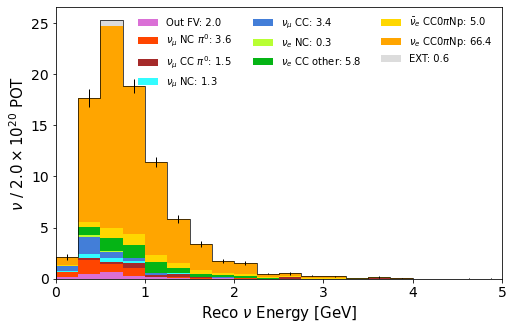

In [43]:
# stat only errors 

x = plot_mc('NeutrinoEnergy2_GeV', [x/4 for x in range(21)], 0, 5, selected_query, datasets_bdt, 
            ISRUN3, x_label="Reco $\\nu$ Energy [GeV]", norm='data', pot='$2.0\\times10^{20}$')

# Systematics

In [44]:
print('max selected neutrino energy [true, GeV] =', max(datasets_bdt['infv'].query(selected_signal_query).nu_e))
print('min selected neutrino energy [true, GeV] =', min(datasets_bdt['infv'].query(selected_signal_query).nu_e))

max selected neutrino energy [true, GeV] = 5.906955242156982
min selected neutrino energy [true, GeV] = 0.19827106595039368


In [45]:
xvar = 'shr_energy_cali'

xvar_dict = xsec_variables(xvar, ISRUN3)

bins = xvar_dict['bins']
true_var = xvar_dict['true_var']
x_label = xvar_dict['x_label']
beamon_pot = xvar_dict['beamon_pot']
xlow = xvar_dict['xlow']
xhigh = xvar_dict['xhigh']


In [46]:
xsec_units = False
plot_variations = True
plot_cov = False
background_subtract = False

q = selected_query 

n_target = parameters(ISRUN3)['n_target']
flux = parameters(ISRUN3)['integrated_flux_per_pot'] * parameters(ISRUN3)['beamon_pot']

 need to update systematic uncertainties ! 
total selected = 88.78524770215373


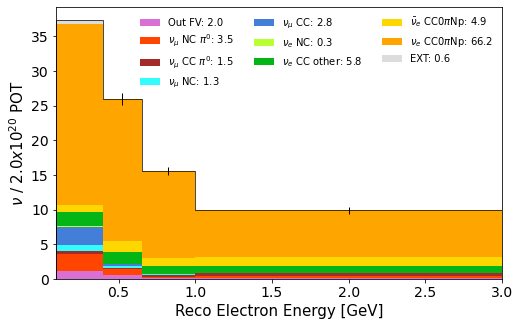

In [47]:
# stat only -- SCALES TO DATA

x = plot_mc(xvar, bins, xlow, xhigh, selected_query, datasets_bdt, ISRUN3, 
            norm='data', sys=False, x_label='Reco '+x_label, save=False, save_label="wide", 
            pot="$2.0 x 10^{20}$")


### PPFX

In [ ]:
importlib.reload(uncertainty_functions)
from uncertainty_functions import *

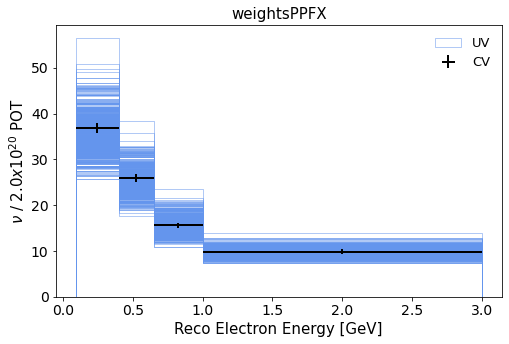

number of universes =  600


In [48]:
ncv, ppfx_variations = plotSysVariations(true_var, xvar, bins, xlow, xhigh, q, datasets_bdt, 'weightsPPFX',600, 
                                         ISRUN3, plot=plot_variations, axis_label='Reco '+x_label, pot='$2.0 x 10^{20}$ POT', 
                                              background_subtraction=background_subtract)

ppfx_dict = calcCov(xvar, bins, ncv, ppfx_variations, plot=plot_cov, save=False, 
                    axis_label='Reco '+x_label, pot='$2.0 x 10^{20}$ POT', isrun3=ISRUN3)

### Beamline Geometry

[0, 1]


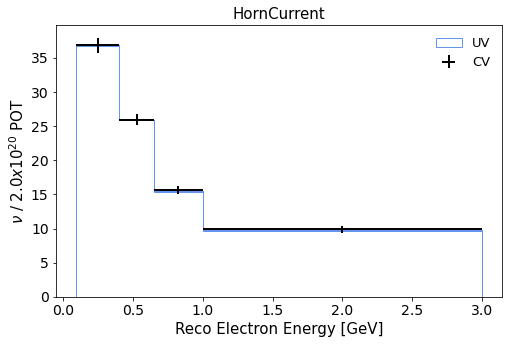

number of universes =  2
[2, 3]


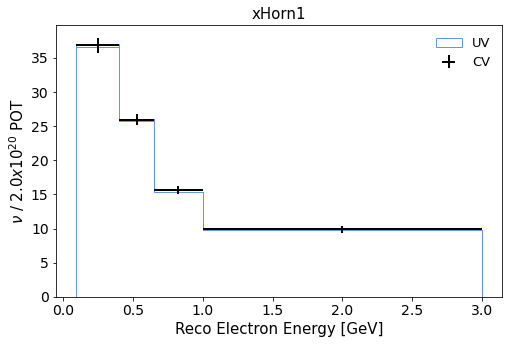

number of universes =  2
[4, 5]


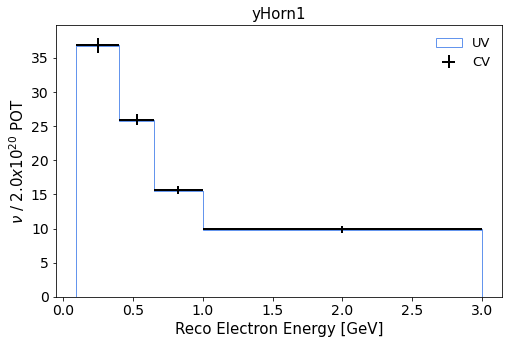

number of universes =  2
[6, 7]


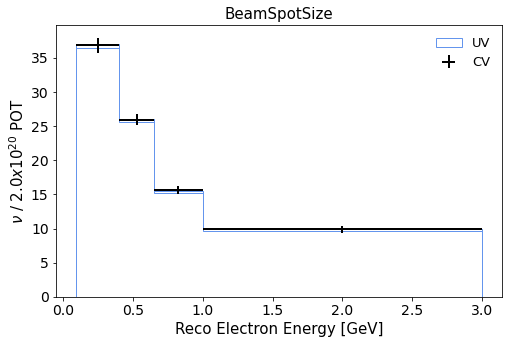

number of universes =  2
[8, 9]


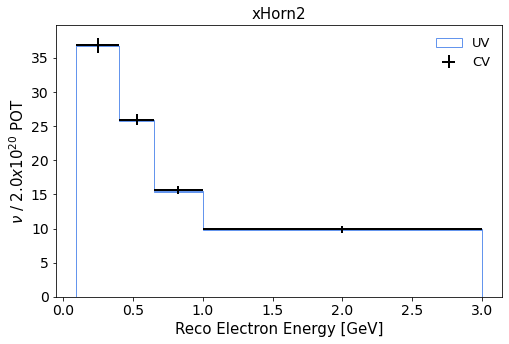

number of universes =  2
[10, 11]


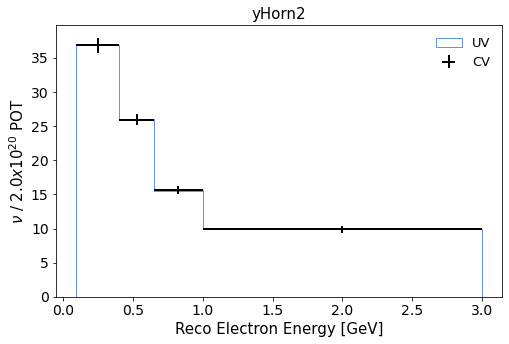

number of universes =  2
[12, 13]


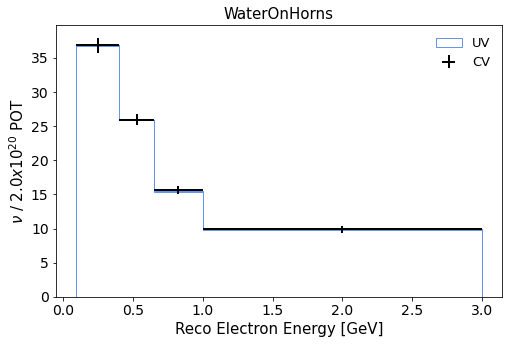

number of universes =  2
[14, 15]


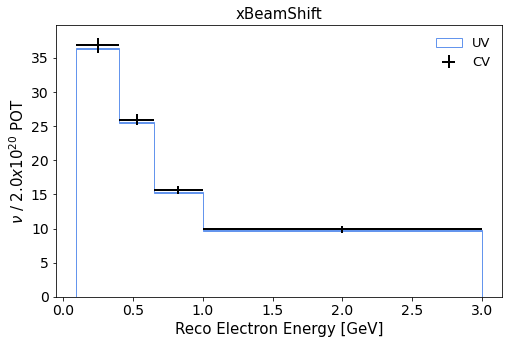

number of universes =  2
[16, 17]


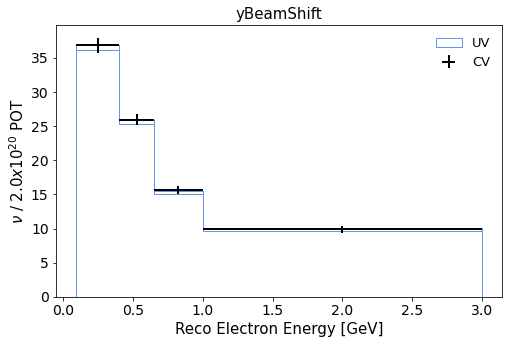

number of universes =  2
[18, 19]


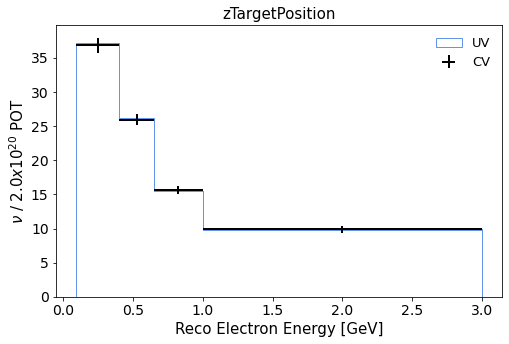

number of universes =  2


In [49]:
# ordered by beamline variation run number
# [+1sigma run #, -1sigma run #]

beamline_runs = {
    'HornCurrent' : [1, 2], 
    'xHorn1' : [3, 4], 
    'yHorn1' : [5, 6], 
    'BeamSpotSize' : [7, 8], 
    'xHorn2' : [9, 10], 
    'yHorn2' : [11, 12], 
    'WaterOnHorns' : [13, 14], 
    'xBeamShift' : [15, 16], 
    'yBeamShift' : [17, 18], 
    'zTargetPosition' : [19, 20]    
}

beamline_cov = {}

# index in weightsNuMIGeo are offset by -1

for variation in beamline_runs.keys(): 
    
    idx = [i-1 for i in beamline_runs[variation]]
    print(idx)
    
    ncv, beamline_variations = plotSysVariations(true_var, xvar, bins, xlow, xhigh, q, datasets_bdt, 'weightsNuMIGeo', 
                                                 idx, ISRUN3, plot=True, axis_label='Reco '+x_label, pot='$2.0 x 10^{20}$ POT', 
                                                  background_subtraction=background_subtract, title=variation)
    
    # calc covariance 
    beamline_cov[variation] = calcCov(xvar, bins, ncv, beamline_variations, plot=plot_cov, save=False, 
                    axis_label='Reco '+x_label, pot='$2.0 x 10^{20}$ POT', isrun3=ISRUN3)
    



In [50]:
# compute total covariance, correlation, & uncertainty 

cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for variation in beamline_cov.keys(): 
    
    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):
            
            cov[i][j] = sum([beamline_cov[x]['cov'][i][j] for x in beamline_cov.keys()])
            
            if ncv[i]*ncv[j] != 0: 
                frac_cov[i][j] = cov[i][j]/(ncv[i]*ncv[j])

            
for i in range(len(bins)-1): 
    for j in range(len(bins)-1):
        
        if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))
            
beamline_dict = {
    'cov' : cov, 
    'frac_cov' : frac_cov,
    'cor' : cor,
    'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
} 

### GENIE multisims

make sure to update this calculation for background subtraction on real/fake data!


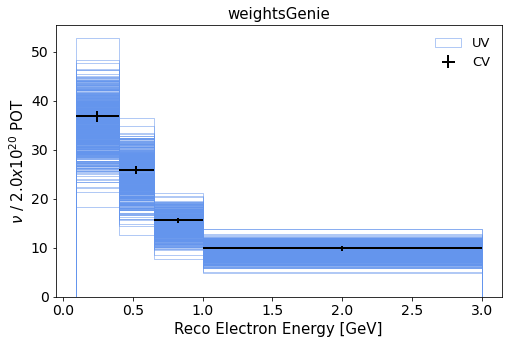

number of universes =  600


In [51]:
ncv, genie_variations = plotSysVariations(true_var, xvar, bins, xlow, xhigh, q, datasets_bdt, 'weightsGenie', 600, 
                                         ISRUN3, plot=plot_variations, axis_label='Reco '+x_label, pot='$2.0 x 10^{20}$ POT', 
                                              background_subtraction=background_subtract)

genie_dict = calcCov(xvar, bins, ncv, genie_variations, plot=plot_cov, save=False, 
                    axis_label='Reco '+x_label, pot='$2.0 x 10^{20}$ POT', isrun3=ISRUN3)

### GENIE unisims 

make sure to update this calculation for background subtraction on real/fake data!


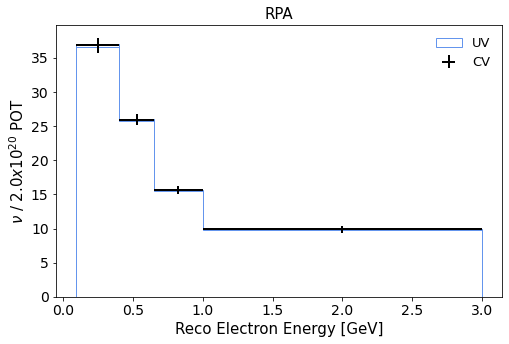

number of universes =  2
make sure to update this calculation for background subtraction on real/fake data!


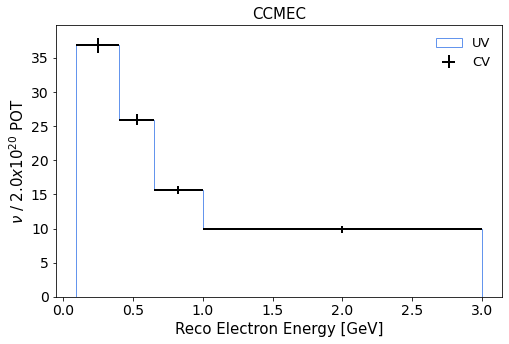

number of universes =  1
make sure to update this calculation for background subtraction on real/fake data!


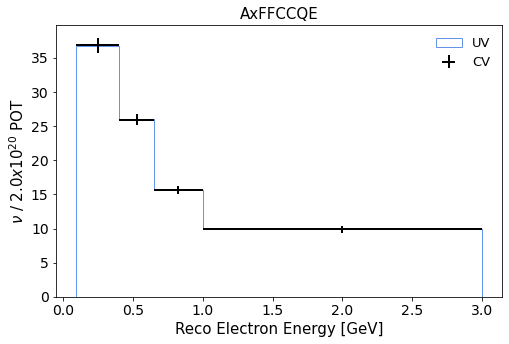

number of universes =  1
make sure to update this calculation for background subtraction on real/fake data!


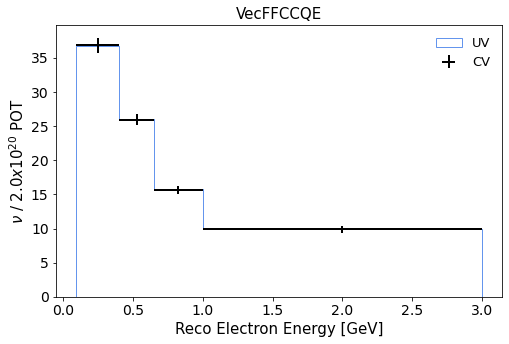

number of universes =  1
make sure to update this calculation for background subtraction on real/fake data!


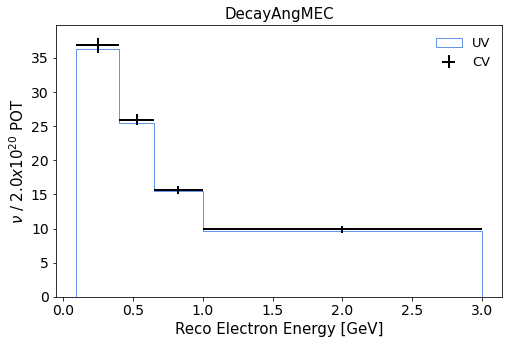

number of universes =  1
make sure to update this calculation for background subtraction on real/fake data!


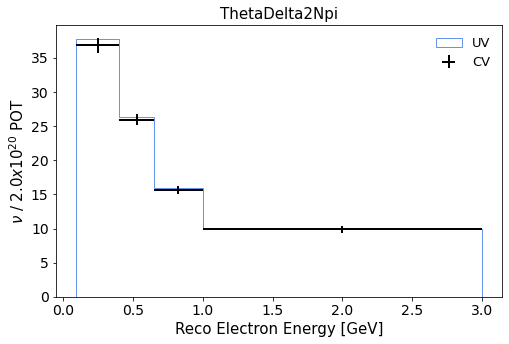

number of universes =  1
make sure to update this calculation for background subtraction on real/fake data!


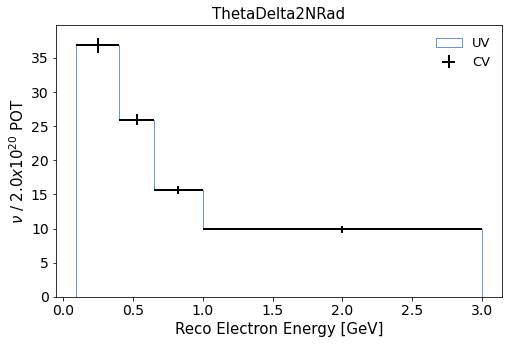

number of universes =  1
make sure to update this calculation for background subtraction on real/fake data!


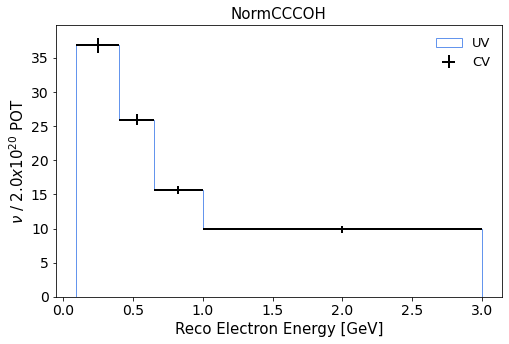

number of universes =  1
make sure to update this calculation for background subtraction on real/fake data!


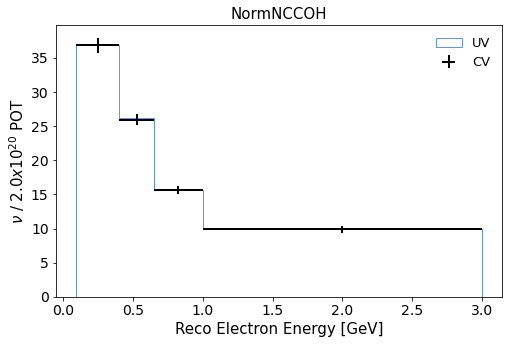

number of universes =  1
make sure to update this calculation for background subtraction on real/fake data!


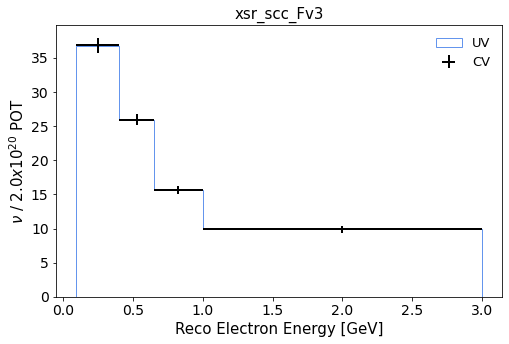

number of universes =  1
make sure to update this calculation for background subtraction on real/fake data!


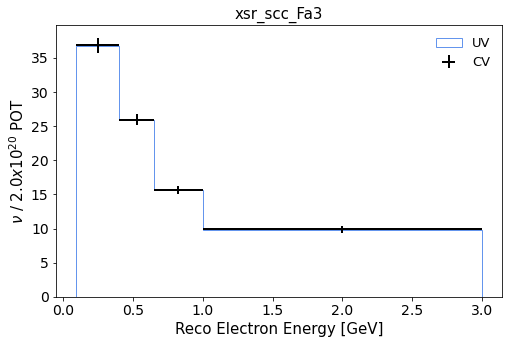

number of universes =  1


In [52]:

# divide the tune weight out of everything except SCC variations
# don't divide the tune weight out of SCC variations 

genie_unisim_variations = ['RPA', 
                           'CCMEC', 'AxFFCCQE', 'VecFFCCQE', 'DecayAngMEC', 'ThetaDelta2Npi', 'ThetaDelta2NRad', 
                          'NormCCCOH', 'NormNCCOH', 
                          'xsr_scc_Fv3', 'xsr_scc_Fa3']


genie_unisim_cov = {}


for knob in genie_unisim_variations: 
    
    if knob == 'RPA': 
        idx = [sys_genie[2:].index('knobRPAup'), sys_genie[2:].index('knobRPAdn')]
    
    else: 
        idx = [sys_genie[2:].index('knob'+knob+'up')]
    
    ncv, variations = plotSysVariations(true_var, xvar, bins, xlow, xhigh, q, datasets_bdt, 'weightsGenieUnisim', 
                                                 idx, ISRUN3, plot=plot_variations, axis_label='Reco '+x_label, pot='$2.0 x 10^{20}$ POT', 
                                                  background_subtraction=background_subtract, title=knob)
    
    # calc covariance 
    genie_unisim_cov[knob] = calcCov(xvar, bins, ncv, variations, plot=plot_cov, save=False, 
                    axis_label='Reco '+x_label, pot='$2.0 x 10^{20}$ POT', isrun3=ISRUN3)
    

In [53]:
# compute total covariance, correlation, & uncertainty 

cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for variation in genie_unisim_cov.keys(): 
    
    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):
            
            cov[i][j] = sum([genie_unisim_cov[x]['cov'][i][j] for x in genie_unisim_cov.keys()])
            
            if ncv[i]*ncv[j] != 0: 
                frac_cov[i][j] = cov[i][j]/(ncv[i]*ncv[j])

            
for i in range(len(bins)-1): 
    for j in range(len(bins)-1):
        
        if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))
            
genie_unisim_dict = {
    'cov' : cov, 
    'frac_cov' : frac_cov,
    'cor' : cor,
    'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
} 

In [54]:
genie_unisim_dict['fractional_uncertainty']

array([0.02989471, 0.02648341, 0.02193582, 0.02358331])

### GEANT4 

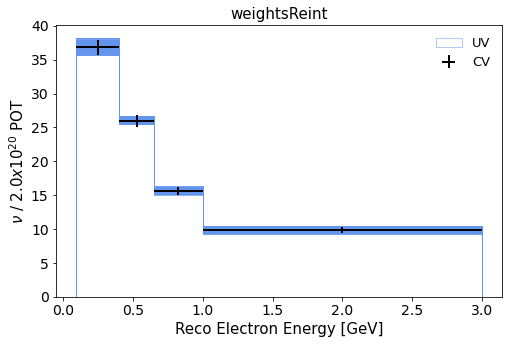

number of universes =  1000


In [55]:
ncv, geant4_variations = plotSysVariations(true_var, xvar, bins, xlow, xhigh, q, datasets_bdt, 'weightsReint', 1000, 
                                         ISRUN3, plot=plot_variations, axis_label='Reco '+x_label, pot='$2.0 x 10^{20}$ POT', 
                                              background_subtraction=background_subtract)

geant4_dict = calcCov(xvar, bins, ncv, geant4_variations, plot=plot_cov, save=False, 
                    axis_label='Reco '+x_label, pot='$2.0 x 10^{20}$ POT', isrun3=ISRUN3)

### Detector Systematics

#### Create ROOT file with BDT-selected detector variations 

In [56]:
recreate_file = False

In [57]:
# skip this step if it is already created
# should manually delete the file first 
# (located here: /uboone/data/users/kmiller/uBNuMI_CCNp/ntuples/runX/systematics/detvar/)

# scales to the det sys CV POT (standard overlay)


if recreate_file: 
    for v in list(detvar_run1_fhc.keys()): 
        NuMIDetSysWeights.makehist_detsys(v, ISRUN3, "NuMI_FHC_BDT_DetectorVariations_MARCH2022.root", xvar, 
                                          bins, cut=q, useBDT=True)
        


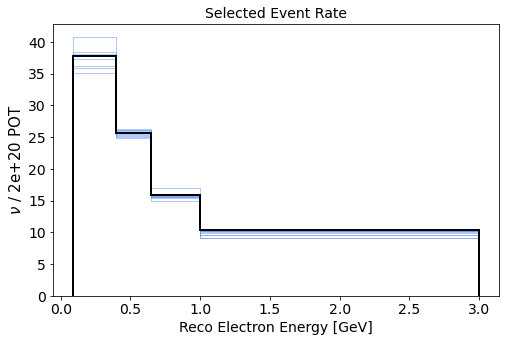

In [58]:
detector_variations = NuMIDetSysWeights.plot_variations(xvar, bins, "NuMI_FHC_BDT_DetectorVariations_MARCH2022.root", ISRUN3, 
                                                        axis_label='Reco '+x_label, 
                                                        plot=plot_variations, background_subtraction=background_subtract)

In [59]:
# compute covariance (N=1 for each variation)

detsys_cov = {}

for variation in detector_variations.keys(): 
    
    if variation=='CV': 
        continue
    
    # calc covariance for each unisim 
    detsys_cov[variation] = calcCov(xvar, bins, detector_variations['CV'], [detector_variations[variation]], 
                                    plot=plot_cov, save=False, axis_label='Reco '+x_label, pot='$2.0 x 10^{20}$ POT', isrun3=ISRUN3,
                                   title=variation)

number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1


In [60]:
# compute total covariance, correlation, & uncertainty 

cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for variation in detsys_cov.keys(): 
    
    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):
            
            cov[i][j] = sum([detsys_cov[x]['cov'][i][j] for x in detsys_cov.keys()])
            
            if detector_variations['CV'][i]*detector_variations['CV'][j] != 0: 
                frac_cov[i][j] = cov[i][j]/(detector_variations['CV'][i]*detector_variations['CV'][j])

            
for i in range(len(bins)-1): 
    for j in range(len(bins)-1):
        
        if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))
            
detsys_dict = {
    'cov' : cov, 
    'frac_cov' : frac_cov,
    'cor' : cor,
    'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
} 

### Stat Uncertainty (MC)

In [ ]:
# if GENIE closure test : uncertainty on the full estimated event rate 
# if fake/real data : uncertainty on the MC background only  

 need to update systematic uncertainties ! 
total selected = 88.78524770215373


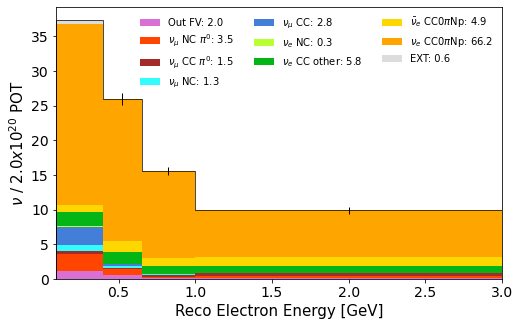

In [61]:
full_event_rate = plot_mc(xvar, bins, xlow, xhigh, q, datasets_bdt, ISRUN3, 
            norm='data', sys=False, x_label='Reco '+x_label, pot="$2.0 x 10^{20}$")['CV']

In [62]:
# on the MC background events only (for now)
# don't include EXT 

print('Make sure to update for full event rate, background-subtracted, or background only !')

ncv_bkgd_df = pd.concat([datasets_bdt['infv'].copy().query(q+' and is_signal==False'), 
                         datasets_bdt['outfv'].copy().query(q+' and is_signal==False')], ignore_index=True) 


mc_stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
mc_frac_stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]


for i in range(len(bins)-1):

    if i==len(bins)-2: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' <= '+str(bins[i+1])
    else: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' < '+str(bins[i+1])
        
    mc_stat_cov[i][i] = sum(ncv_bkgd_df.query(bin_query).totweight_data ** 2) 
    mc_frac_stat_cov[i][i] = mc_stat_cov[i][i]/ full_event_rate[i]**2 
    
    bin_query = ''
    
mc_stat_percent_error = np.sqrt(np.diag(mc_frac_stat_cov))
mc_stat_percent_error

Make sure to update for full event rate, background-subtracted, or background only !


array([0.02360154, 0.01982935, 0.01928419, 0.03335334])

In [63]:
if plot_cov: 
    fig = plt.figure(figsize=(10, 6))
        
    plt.pcolor(bins, bins, mc_stat_cov, cmap='OrRd', edgecolors='k' )

    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlabel("Reco "+x_label, fontsize=15)
    plt.ylabel("Reco "+x_label, fontsize=15)

    plt.title('MC Statistical Covariance', fontsize=15)

    plt.show()
    
    fig = plt.figure(figsize=(10, 6))
        
    plt.pcolor(bins, bins, mc_frac_stat_cov, cmap='OrRd', edgecolors='k' )

    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlabel("Reco "+x_label, fontsize=15)
    plt.ylabel("Reco "+x_label, fontsize=15)

    plt.title('MC Fractional Statistical Covariance', fontsize=15)

    plt.show()


### Stat Uncertainty Beam On & EXT

In [ ]:
print('need to add in beam on uncertainty!')

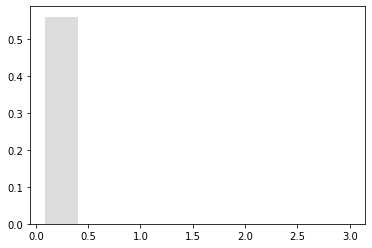

array([0.56120876, 0.        , 0.        , 0.        ])

In [64]:
# selected EXT uncertainty 

selected_ext = plt.hist(datasets_bdt['ext'].copy().query(q)[xvar], bins, 
                        weights=datasets_bdt['ext'].copy().query(q)['pot_scale'], color='gainsboro')[0]
plt.show()
selected_ext


In [65]:
# take fractional with respect to the full event rate

ext_frac_stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for i in range(len(bins)-1): 
    
    if selected_ext[i] != 0: 
        ext_frac_stat_cov[i][i] = selected_ext[i]/(full_event_rate[i]**2)

ext_stat_percent_error = np.sqrt(np.diag(ext_frac_stat_cov))
ext_stat_percent_error

array([0.02004588, 0.        , 0.        , 0.        ])

In [66]:
# do the same thing for beam on data

### MC Response Matrix 

In [67]:
# this is for the signal channel ONLY 

selected_signal_df = datasets_bdt['infv'].query(selected_signal_query).copy()
selected_signal_df['seed'] = selected_signal_df.apply( lambda x: ConcatRunSubRunEvent(x['run'], x['sub'], x['evt']), axis=1 )
selected_signal_df['weightsPoisson'] = selected_signal_df.apply( lambda x: PoissonRandomNumber(x['seed'], mean=1.0, size=1000), axis=1 )


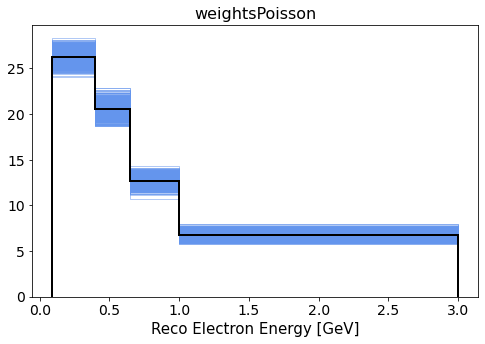

In [72]:
fig = plt.figure(figsize=(8, 5))

# histogram bin counts for all universes
uni_counts = []

for u in range(1000): 

    # multiply in with sys weight of universe u 
    sys_weight = list(selected_signal_df['weightsPoisson'].str.get(u))
    total_weight = [ x*y for x, y in zip(sys_weight, selected_signal_df['totweight_data']) ]

    n, b, p = plt.hist(selected_signal_df[xvar], bins, histtype='step', weights=total_weight, 
                            linewidth=0.5, color='cornflowerblue')  
            
    uni_counts.append(n)



ncv, bcv, pcv = plt.hist(selected_signal_df[xvar], bins, histtype='step', 
                         weights=selected_signal_df['totweight_data'], linewidth=2, color='black')      
        
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
        
plt.xlabel('Reco '+x_label, fontsize=15)

        
plt.ylabel("", fontsize=15)

plt.title('weightsPoisson', fontsize=16)    

        
plt.show()

number of universes =  1000


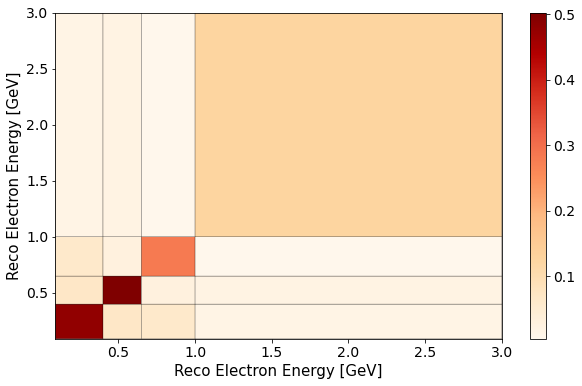

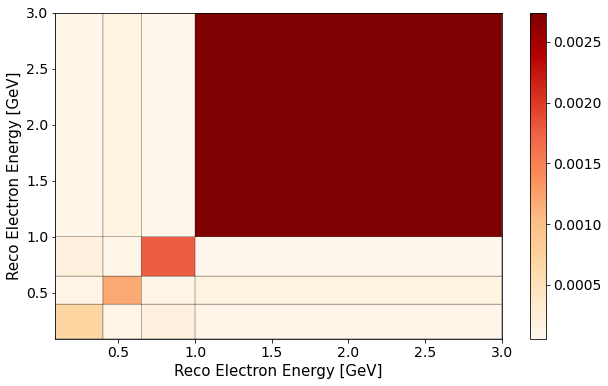

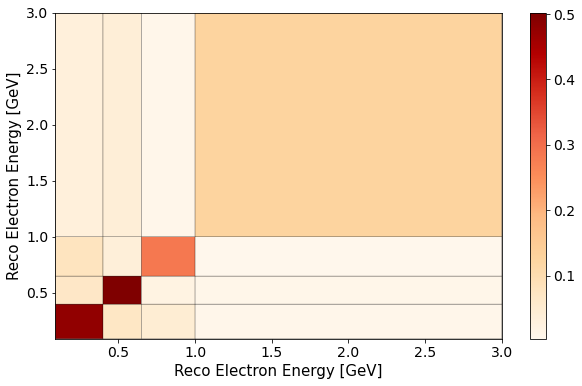

In [71]:
response_matrix_uncertainty = calcCov(xvar, bins, ncv, uni_counts, isrun3=ISRUN3, plot=True, 
                   save=False, axis_label='Reco '+x_label, pot=parameters(ISRUN3)['beamon_pot'])

### POT Counting (2%)

In [73]:
# uncertainty with respect to the background-subtracted event rate

if background_subtract: 

    ncv_bkgd = plot_mc(xvar, bins, xlow, xhigh, selected_query, datasets_bdt, ISRUN3, 
            norm='data', sys=False, x_label='Reco '+x_label, pot="$2.0 x 10^{20}$")['background_counts']
    
    bkgd_cv_counts = ncv_bkgd

else: 
    bkgd_cv_counts = None


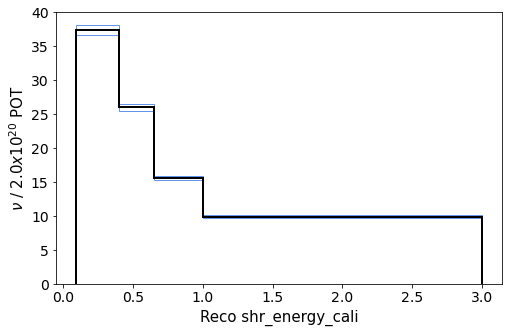

number of universes =  2


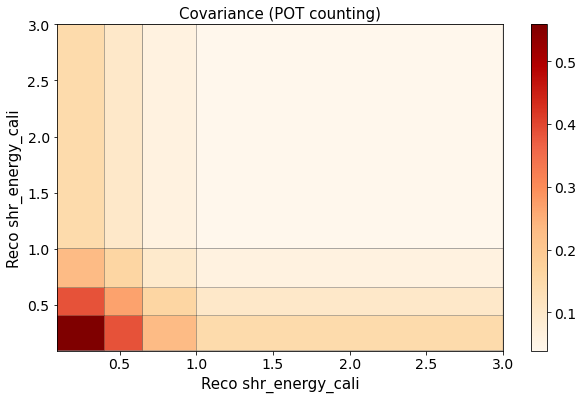

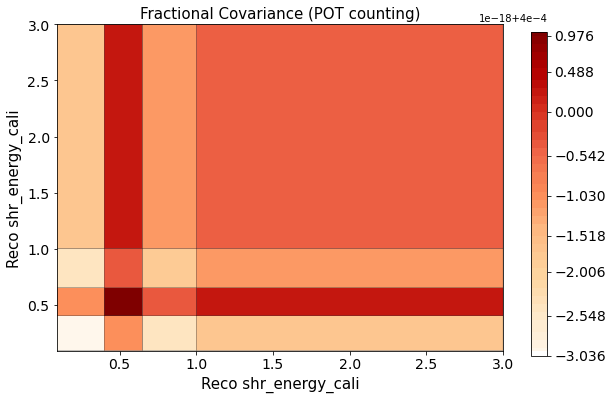

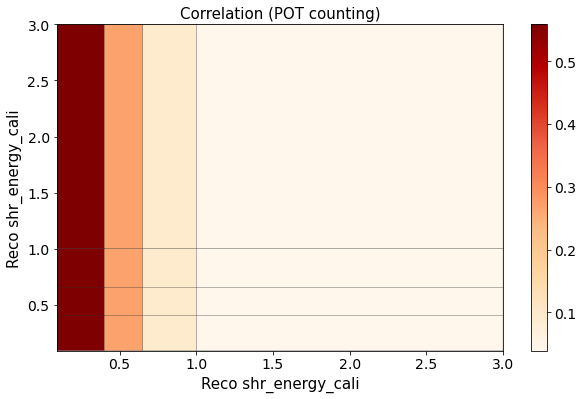

In [74]:
pot_counting = pot_unisims(xvar, full_event_rate, bins, 0.02, ISRUN3, plot=True, x_label=None, bkgd_cv_counts=bkgd_cv_counts)

### Dirt (100%)  

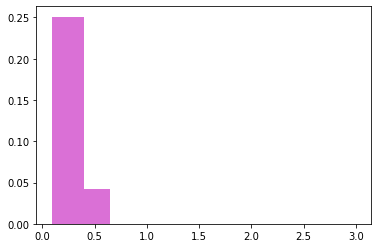

In [75]:
# selected dirt uncertainty 
# vary the dirt interactions by 100% (1 unisim) on the background-subtracted selected event rate

selected_dirt = plt.hist(datasets_bdt['outfv'].copy().query(q+' and isDirt==1')[xvar], bins, 
                        weights=datasets_bdt['outfv'].copy().query(q+' and isDirt==1')['pot_scale'], color='orchid')[0]

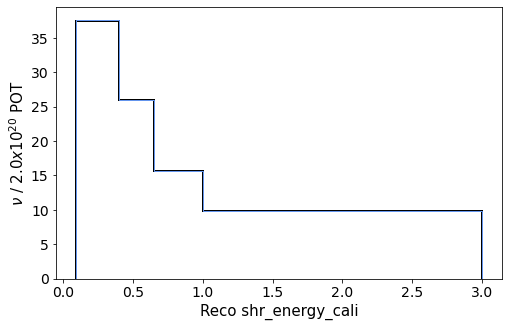

number of universes =  1


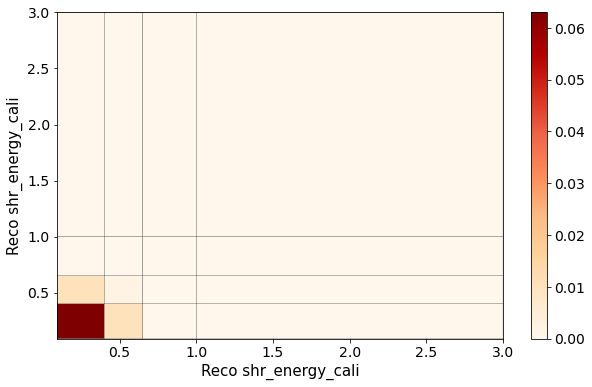

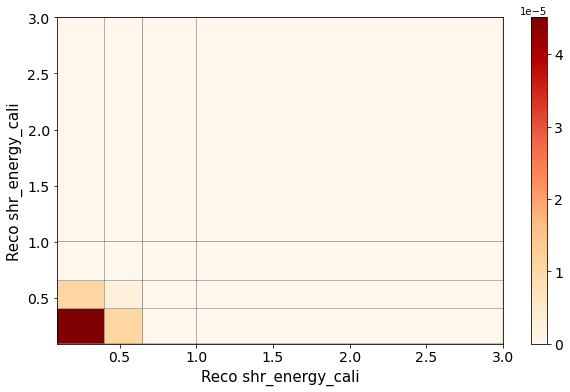

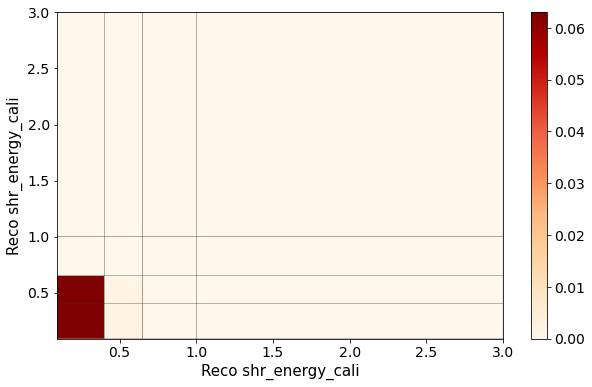

In [76]:
dirt_uncertainty = dirt_unisim(xvar, bins, full_event_rate, selected_dirt, 1.0, ISRUN3, plot=True, 
                               x_label=None, title=None, bkgd_cv_counts=bkgd_cv_counts)

## All Sources of Uncertainty

In [87]:

frac_cov_dict = {
    'ppfx' : ppfx_dict['frac_cov'], 
    'beamline' : beamline_dict['frac_cov'], 
    'genie_ms' : genie_dict['frac_cov'], 
    'genie_us': genie_unisim_dict['frac_cov'], 
    'geant4' : geant4_dict['frac_cov'],
    'detector' : detsys_dict['frac_cov'], 
    'pot_counting' : pot_counting['frac_cov'], 
    'dirt' : dirt_uncertainty['frac_cov'],
    'mc_stat' : mc_frac_stat_cov, 
    'ext_stat' : ext_frac_stat_cov
    #'response_matrix' : response_matrix_uncertainty['frac_cov']
}



make sure to update for full or background subtracted event rate!
Note: Input must be fractional covariance matrices !


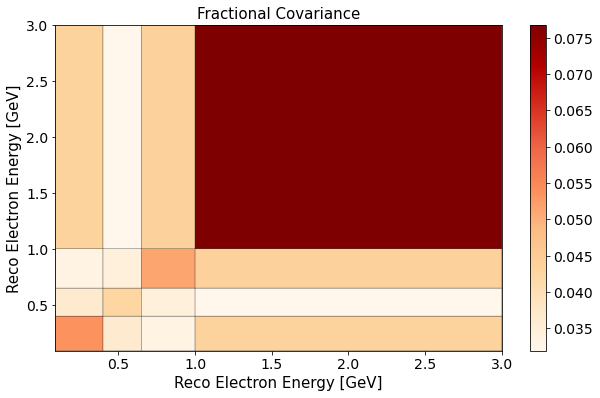

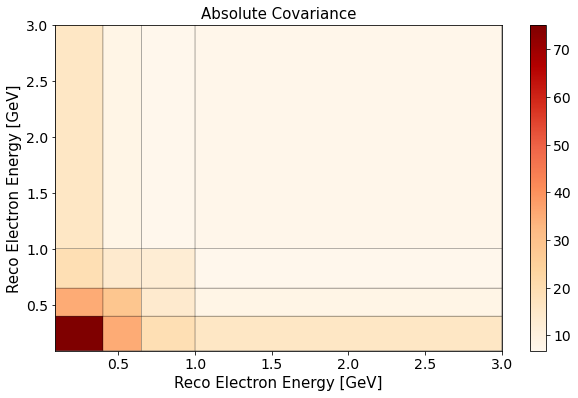

In [88]:
print("make sure to update for full or background subtracted event rate!")

cv = full_event_rate

tot_frac_cov, tot_abs_cov = plotFullCov(frac_cov_dict, xvar, cv, bins, xlow, xhigh, save=False, 
                      axis_label='Reco '+x_label, isrun3=ISRUN3, pot='$2.0 x 10^{20}$ POT')

In [89]:
# add ppfx & beamline geometry in quadrature
frac_cov_dict['flux'] = [ [x+y for x,y in zip(a,b)] for a,b in zip(frac_cov_dict['ppfx'], frac_cov_dict['beamline'])]


In [90]:
# add genie in quadrature
frac_cov_dict['genie_all'] = [ [x+y for x,y in zip(a,b)] for a,b in zip(frac_cov_dict['genie_ms'], frac_cov_dict['genie_us'])]


In [93]:
# add stat stuff in quadrature 

print("make sure to update with response matrix and/or beam on data! ")

# MC stat
# EXT stat
# BEAM ON stat
# response matrix 

frac_cov_dict['stat_all'] = [ [x+y for x,y in zip(a,b)] for a,b in zip(frac_cov_dict['mc_stat'], frac_cov_dict['ext_stat'])]


make sure to update with response matrix and/or beam on data! 


In [100]:
frac_unc_dict = {
    'flux' : np.diagonal(frac_cov_dict['flux']), 
    'genie' : np.diagonal(frac_cov_dict['genie_all']), 
    'geant4' : np.diagonal(frac_cov_dict['geant4']),
    'detector' : np.diagonal(frac_cov_dict['detector']), 
    'pot_counting' : np.diagonal(frac_cov_dict['pot_counting']), 
    'dirt' : np.diagonal(frac_cov_dict['dirt']),
    'stat' : np.diagonal(frac_cov_dict['stat_all'])
}

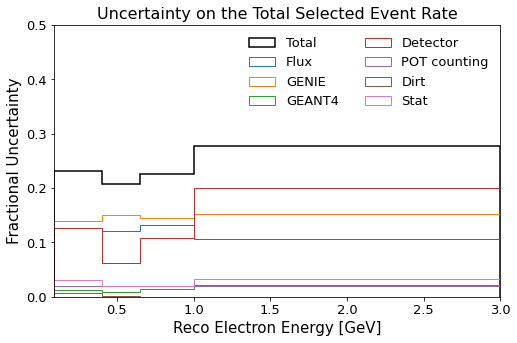

In [99]:
bincenters = 0.5*(np.array(bins)[1:]+np.array(bins)[:-1])
#colors = ['#6699CC', '#004488', '#EECC66', '#994455', '#997700', '#EE99AA', 'lightskyblue']

fig = plt.figure(figsize=(8, 5))  

# TOTAL 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Total",
        weights=np.sqrt(np.diagonal(tot_frac_cov)), linewidth=1.5, color='black')

# FLUX
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Flux", 
         weights=np.sqrt(np.diagonal(frac_cov_dict['flux'])))

# CROSS SECTION MODELS 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="GENIE", 
         weights=np.sqrt(np.diagonal(frac_cov_dict['genie_ms'])))
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="GEANT4", 
         weights=np.sqrt(np.diagonal(frac_cov_dict['geant4'])))

# DETECTOR 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Detector", 
         weights=np.sqrt(np.diagonal(frac_cov_dict['detector'])))

# POT COUNTING 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="POT counting",
        weights=np.sqrt(np.diagonal(frac_cov_dict['pot_counting'])))

# DIRT 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Dirt",
        weights=np.sqrt(np.diagonal(frac_cov_dict['dirt'])))

# STATISTICAL 
#plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Response matrix",
#        weights=np.sqrt(np.diagonal(frac_cov_dict['response_matrix'])))

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Stat",
        weights=np.sqrt(np.diagonal(frac_cov_dict['stat_all'])))


plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel('Reco '+x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, .5)

plt.legend(fontsize=13, frameon=False, ncol=2)
plt.title("Uncertainty on the Total Selected Event Rate", fontsize=16)

#plt.savefig(plots_path+xvar+"_FracUncertainty.pdf", transparent=True, bbox_inches='tight')

plt.show()

## Save covariance to unfolding file 

In [ ]:
hcov = TH2D("hcov_tot", "Covariance Matrix vs. Reco "+x_label, 
            len(bins)-1, np.array(bins), len(bins)-1, np.array(bins))

for i in range(len(bincenters)): # i = row (y)
    for j in range(len(bincenters)): # j = column (x) 

        hcov.Fill(bincenters[j], bincenters[i], tot_abs_cov[i][j]) 
        
        #print('x = '+str(j), 'y = '+str(i), 'counts = '+ str(w))


In [ ]:
f = ROOT.TFile.Open("/uboone/data/users/kmiller/unfolding/WSVD_"+xvar+"_FHCRUN1_MARCH12.root", "UPDATE")

In [ ]:
f.cd()
hcov.Write()
f.Close()

## Data/MC Comparisons -- TK

## NuMI Oscillations (3+1 Model)

In [ ]:
# outdated 

x = plot_mc(xvar, [round(0.01*x, 2) for x in range(0, 75, 5)], 0, 0.7, 'BDT_score>0.575', datasets_bdt, ISRUN3, 
        plt_norm='proj', pot='$9.23\\times10^{20}$', ymax=30, x_label='True Neutrino Energy [GeV]', osc='machado_bestfit.csv')

# osc='biggest_variation.csv'

#### Create projected oscillation dictionary 

In [ ]:
import json

In [ ]:
# to load a stored dictionary 
with open('outdated/FHC_Projected_TrueNeutrinoEnergy.json') as f:
    d = json.load(f)

In [ ]:
bins = np.linspace(0, 4.5, 46) #d['bins']

In [ ]:
x = plot_mc('nu_e', bins, 0, 5, selected_query, datasets_bdt, 
            ISRUN3, x_label="Reco $\\nu$ Energy [GeV]", norm='data', pot='$2.0\\times10^{20}$')

In [ ]:
oscillation_dict = {}

In [ ]:
oscillation_dict['bins'] = bins

In [ ]:
pot_scale = 9.23E20/parameters(ISRUN3)['beamon_pot']
print(pot_scale)

In [ ]:
oscillation_dict['CV'] = [k*pot_scale for k in x['CV']]

In [ ]:
ncv, ppfx_variations = plotSysVariations('nu_e', 'nu_e', bins, bins[0], bins[-1], selected_query, datasets_bdt, 'weightsPPFX',600, 
                                         ISRUN3, plot=False, axis_label='True Neutrino Energy [GeV]', pot='$2.0 x 10^{20}$ POT', 
                                              background_subtraction=False)

ppfx_dict = calcCov('nu_e', bins, ncv, ppfx_variations, plot=False, save=False, 
                    axis_label='True Neutrino Energy [GeV] ', pot='$2.0 x 10^{20}$ POT', isrun3=ISRUN3, title='Hadron Production')

In [ ]:
oscillation_dict['ppfx_cov_frac'] = ppfx_dict['frac_cov']

In [ ]:
ncv, genie_variations = plotSysVariations('nu_e', 'nu_e', bins, bins[0], bins[-1], selected_query, datasets_bdt, 'weightsGenie',600, 
                                         ISRUN3, plot=True, axis_label='True Neutrino Energy [GeV]', pot='$2.0 x 10^{20}$ POT', 
                                              background_subtraction=False)

genie_dict = calcCov('nu_e', bins, ncv, genie_variations, plot=False, save=False, 
                    axis_label='True Neutrino Energy [GeV] ', pot='$2.0 x 10^{20}$ POT', isrun3=ISRUN3, title='Hadron Production')

In [ ]:
oscillation_dict['genie_cov_frac'] = genie_dict['frac_cov']

In [ ]:
ncv, geant4_variations = plotSysVariations('nu_e', 'nu_e', bins, bins[0], bins[-1], selected_query, datasets_bdt, 'weightsReint',1000, 
                                         ISRUN3, plot=True, axis_label='True Neutrino Energy [GeV]', pot='$2.0 x 10^{20}$ POT', 
                                              background_subtraction=False)


geant4_dict = calcCov('nu_e', bins, ncv, geant4_variations, plot=False, save=False, 
                    axis_label='True Neutrino Energy [GeV] ', pot='$2.0 x 10^{20}$ POT', isrun3=ISRUN3, title='Hadron Production')

In [ ]:
oscillation_dict['reint_cov_frac'] = geant4_dict['frac_cov']

In [ ]:
## detector variations -- make new file 
recreate_file=True

In [ ]:
if recreate_file: 
    for v in list(detvar_run1_fhc.keys()): 
        NuMIDetSysWeights.makehist_detsys(v, ISRUN3, "NuMI_FHC_BDT_DetectorVariations_OscillationAnalysis_v2.root", 'nu_e', 
                                          bins, cut=selected_query, useBDT=True)

In [ ]:
detector_variations = NuMIDetSysWeights.plot_variations('nu_e', bins, "NuMI_FHC_BDT_DetectorVariations_OscillationAnalysis_v2.root", 
                                                        ISRUN3, axis_label='True Neutrino Energy', plot=True, background_subtraction=False)

In [ ]:
# compute covariance (N=1 for each variation)

detsys_cov = {}

# index in weightsNuMIGeo are offset by -1

for variation in detector_variations.keys(): 
    
    if variation=='CV': 
        continue
    
    # calc covariance for each unisim 
    detsys_cov[variation] = calcCov('nu_e', bins, detector_variations['CV'], [detector_variations[variation]], 'Detector', 
                                    plot=False, save=False, pot='$2.0 x 10^{20}$ POT', isrun3=ISRUN3,
                                   title=variation)

In [ ]:
# compute total covariance, correlation, & uncertainty 

cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for variation in detsys_cov.keys(): 
    
    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):
            
            cov[i][j] = sum([detsys_cov[x]['cov'][i][j] for x in detsys_cov.keys()])
            
            if detector_variations['CV'][i]*detector_variations['CV'][j] != 0: 
                frac_cov[i][j] = cov[i][j]/(detector_variations['CV'][i]*detector_variations['CV'][j])

            
for i in range(len(bins)-1): 
    for j in range(len(bins)-1):
        
        if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))
            
detsys_dict = {
    'cov' : cov, 
    'frac_cov' : frac_cov,
    'cor' : cor,
    'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
} 

In [ ]:
oscillation_dict['det_cov_frac'] = detsys_dict['frac_cov']

In [ ]:
tot_frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for source in list(oscillation_dict.keys())[2:]: 
    tot_frac_cov = [ [x+y for x,y in zip(a,b)] for a,b in zip(tot_frac_cov, oscillation_dict[source])]

In [ ]:
oscillation_dict['tot_cov_frac'] = tot_frac_cov

In [ ]:
oscillation_dict.keys()


In [ ]:
oscillation_dict['bins'] = oscillation_dict['bins'].tolist()

In [ ]:
# save this dictionary 

with open('mun/FHC_Projected_TrueNeutrinoEnergy_March2022_v2.json', 'w') as f:
    json.dump(oscillation_dict, f)